<a href="https://colab.research.google.com/github/kannankumar/jupyter-notebooks/blob/hindi-digit-gan/Hindi_Digits_CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hindi Digits CNN

#### Classifying Images of Handwritten Hindi Digits

---

In this notebook, we train a CNN to classify images from a subset of the Devanagiri Dataset. This dataset contains both characters and numerals in the Devanigiri script. We use only the numerals for our Hindi Digit  classification.  

And here are how the numeric digits(0-9) look like (*first row*), their pronounciation (*second row*) and the decimal equivalent (*last row*):

![Hindi Digits](https://i.imgur.com/Ck4r3uG.png)



### 0. Download Dataset and Extract Devanagiri Character Images
[UCI Machine Learning Repository]((http://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset)) hosts this dataset.  
So I'll be downloading it from there.

In [0]:
%%bash
wget -q http://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip
unzip -q DevanagariHandwrittenCharacterDataset.zip

In [2]:
import fnmatch
import os
import shutil

root_dir='DevanagariHandwrittenCharacterDataset'

def count_characters(dir_path):
  
  print(dir_path, 'Directory Details:')
  counts = {dr: len(os.listdir(os.path.join(dir_path, dr))) for dr in sorted(os.listdir(dir_path))}
  print(counts)

count_characters(os.path.join(root_dir, 'Train'))
count_characters(os.path.join(root_dir, 'Test'))

DevanagariHandwrittenCharacterDataset/Train Directory Details:
{'character_10_yna': 1700, 'character_11_taamatar': 1700, 'character_12_thaa': 1700, 'character_13_daa': 1700, 'character_14_dhaa': 1700, 'character_15_adna': 1700, 'character_16_tabala': 1700, 'character_17_tha': 1700, 'character_18_da': 1700, 'character_19_dha': 1700, 'character_1_ka': 1700, 'character_20_na': 1700, 'character_21_pa': 1700, 'character_22_pha': 1700, 'character_23_ba': 1700, 'character_24_bha': 1700, 'character_25_ma': 1700, 'character_26_yaw': 1700, 'character_27_ra': 1700, 'character_28_la': 1700, 'character_29_waw': 1700, 'character_2_kha': 1700, 'character_30_motosaw': 1700, 'character_31_petchiryakha': 1700, 'character_32_patalosaw': 1700, 'character_33_ha': 1700, 'character_34_chhya': 1700, 'character_35_tra': 1700, 'character_36_gya': 1700, 'character_3_ga': 1700, 'character_4_gha': 1700, 'character_5_kna': 1700, 'character_6_cha': 1700, 'character_7_chha': 1700, 'character_8_ja': 1700, 'character_9

In [3]:
def move_images(src_dir, dst_dir):
  
  print('Copying contents from ', src_dir, ' Directory...')

  if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)

  # loop through train dir
  for dr in os.listdir(src_dir):
    # match dr with "digit*"
    src_sub_dir = os.path.join(src_dir, dr)
    if os.path.isdir(src_sub_dir) and fnmatch.fnmatch(dr, 'digit*'):
          print(dr, end=", ")
          
          # copy directory if it matches 'digit*'
          dst_sub_dir = os.path.join(dst_dir, dr)
          shutil.copytree(src=src_sub_dir, dst=dst_sub_dir)
  print('Done!\n\n')
  
move_images(os.path.join(root_dir, 'Train'), 'train-digits')
move_images(os.path.join(root_dir, 'Test'), 'test-digits')

Copying contents from  DevanagariHandwrittenCharacterDataset/Train  Directory...
digit_7, digit_8, digit_1, digit_6, digit_0, digit_4, digit_9, digit_5, digit_2, digit_3, Done!


Copying contents from  DevanagariHandwrittenCharacterDataset/Test  Directory...
digit_7, digit_8, digit_1, digit_6, digit_0, digit_4, digit_9, digit_5, digit_2, digit_3, Done!




Clean up dataset artifacts that we won't need anymore.

In [0]:
!rm -rf DevanagariHandwrittenCharacterDataset
!rm DevanagariHandwrittenCharacterDataset.zip

### 1. Load Images from Directory

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator


# create a data generator

datagen = ImageDataGenerator(rescale=1./255,)        # rescale [0,255] --> [0,1]
                            # width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
                            # height_shift_range=0.2)  # randomly shift images vertically (10% of total height))

# load and iterate training dataset
train_it = datagen.flow_from_directory('train-digits/', target_size=(32,32), color_mode='grayscale', shuffle=True, 
                                       class_mode='categorical', batch_size=64)
# load and iterate test dataset
test_it = datagen.flow_from_directory('test-digits/', target_size=(32,32), color_mode='grayscale', shuffle=True, 
                                      class_mode='categorical', batch_size=64)

Using TensorFlow backend.


Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


### 2. Visualize the First 24 Training Images

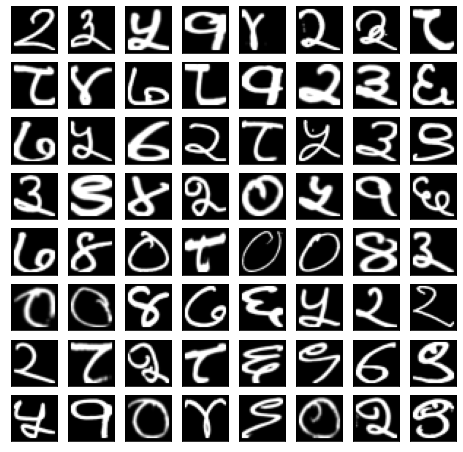

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_loader = iter(train_it)
images, _ = train_loader.next()  # loader keeps a tuple of (image,label)

fig = plt.figure(figsize=(8,8))
for i, img in enumerate(images):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img), cmap='gray')

### 4.  Break Dataset into Training, Testing, and Validation Sets

### 5. Define the Model Architecture 

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)         

### 6. Compile the Model 

In [0]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 7. Train the Model 

In [9]:
from keras.callbacks import ModelCheckpoint   

# checkpoint can only be used with validation accuracy. 
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# train the model
hist = model.fit_generator(train_it, epochs=10, verbose=2, shuffle=True)


Epoch 1/10
 - 16s - loss: 0.3792 - accuracy: 0.8741
Epoch 2/10
 - 16s - loss: 0.0944 - accuracy: 0.9687
Epoch 3/10
 - 16s - loss: 0.0586 - accuracy: 0.9809
Epoch 4/10
 - 16s - loss: 0.0439 - accuracy: 0.9861
Epoch 5/10
 - 15s - loss: 0.0328 - accuracy: 0.9896
Epoch 6/10
 - 16s - loss: 0.0280 - accuracy: 0.9921
Epoch 7/10
 - 16s - loss: 0.0249 - accuracy: 0.9921
Epoch 8/10
 - 15s - loss: 0.0197 - accuracy: 0.9937
Epoch 9/10
 - 16s - loss: 0.0189 - accuracy: 0.9942
Epoch 10/10
 - 16s - loss: 0.0170 - accuracy: 0.9946


In [0]:
model.save('hindi_digit_classification_model.h5')

### 8. Load the Model with the Best Validation Accuracy

In [0]:
# load the weights that yielded the best validation accuracy
# TODO: split train generator to train and valid

# model.load_weights('model.weights.best.hdf5')

### 9. Calculate Classification Accuracy on Test Set

In [12]:
# evaluate and print test accuracy
score = model.evaluate_generator(test_it, verbose=0)
print('\n', 'Test accuracy:', score[1]*100)


 Test accuracy: 99.43333268165588


### 10. Visualize Some Predictions

This may give you some insight into why the network is misclassifying certain objects.

In [0]:
# get predictions on the test set
test_loader = iter(test_it)
test_images, test_labels = test_loader.next()
y_hat = model.predict(test_images)

# define text labels for Hindi Digits
hindi_digit_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

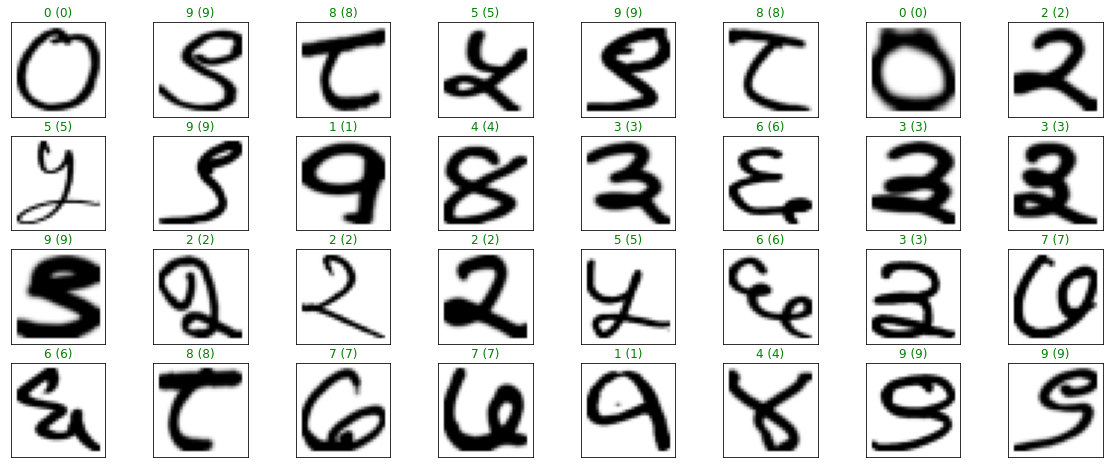

In [14]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(test_images.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_images[idx]), cmap='binary')
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(test_labels[idx])
    ax.set_title("{} ({})".format(hindi_digit_labels[pred_idx], hindi_digit_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))